In [136]:
# 1. Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from xgboost import XGBRegressor, plot_importance


In [137]:
# 2. Load and inspect the dataset
data = pd.read_csv("California_Houses.csv")
data.describe()  # Summary statistics of the dataset

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,2.064000e+04,2.064000e+04,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704,40509.264883,2.694220e+05,3.981649e+05,349187.551219,386688.422291
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532,49140.039160,2.477324e+05,2.894006e+05,217149.875026,250122.192316
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000,120.676447,4.205891e+02,4.849180e+02,569.448118,456.141313
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000,9079.756762,3.211125e+04,1.594264e+05,113119.928682,117395.477505
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000,20522.019101,1.736675e+05,2.147398e+05,459758.877000,526546.661701
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000,49830.414479,5.271562e+05,7.057954e+05,516946.490963,584552.007907
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000,333804.686371,1.018260e+06,1.196919e+06,836762.678210,903627.663298


In [138]:
data.head(10)    # Display the first 10 rows

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
0,452600.0,8.3252,41,880,129,322,126,37.88,-122.23,9263.040773,556529.158342,735501.806984,67432.517001,21250.213767
1,358500.0,8.3014,21,7099,1106,2401,1138,37.86,-122.22,10225.733072,554279.850069,733236.884360,65049.908574,20880.600400
2,352100.0,7.2574,52,1467,190,496,177,37.85,-122.24,8259.085109,554610.717069,733525.682937,64867.289833,18811.487450
3,341300.0,5.6431,52,1274,235,558,219,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
4,342200.0,3.8462,52,1627,280,565,259,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
5,269700.0,4.0368,52,919,213,413,193,37.85,-122.25,7768.086571,555194.266086,734095.290744,65287.138412,18031.047568
6,299200.0,3.6591,52,2535,489,1094,514,37.84,-122.25,6843.020847,554364.406936,733249.808578,64315.991742,17538.209972
7,241400.0,3.1200,52,3104,687,1157,647,37.84,-122.25,6843.020847,554364.406936,733249.808578,64315.991742,17538.209972
8,226700.0,2.0804,42,2555,665,1206,595,37.84,-122.26,6363.948013,554949.749519,733820.824419,64751.463863,16744.406584
9,261100.0,3.6912,52,3549,707,1551,714,37.84,-122.25,6843.020847,554364.406936,733249.808578,64315.991742,17538.209972


In [139]:
data.isnull().sum()  # Check for missing values

Median_House_Value          0
Median_Income               0
Median_Age                  0
Tot_Rooms                   0
Tot_Bedrooms                0
Population                  0
Households                  0
Latitude                    0
Longitude                   0
Distance_to_coast           0
Distance_to_LA              0
Distance_to_SanDiego        0
Distance_to_SanJose         0
Distance_to_SanFrancisco    0
dtype: int64

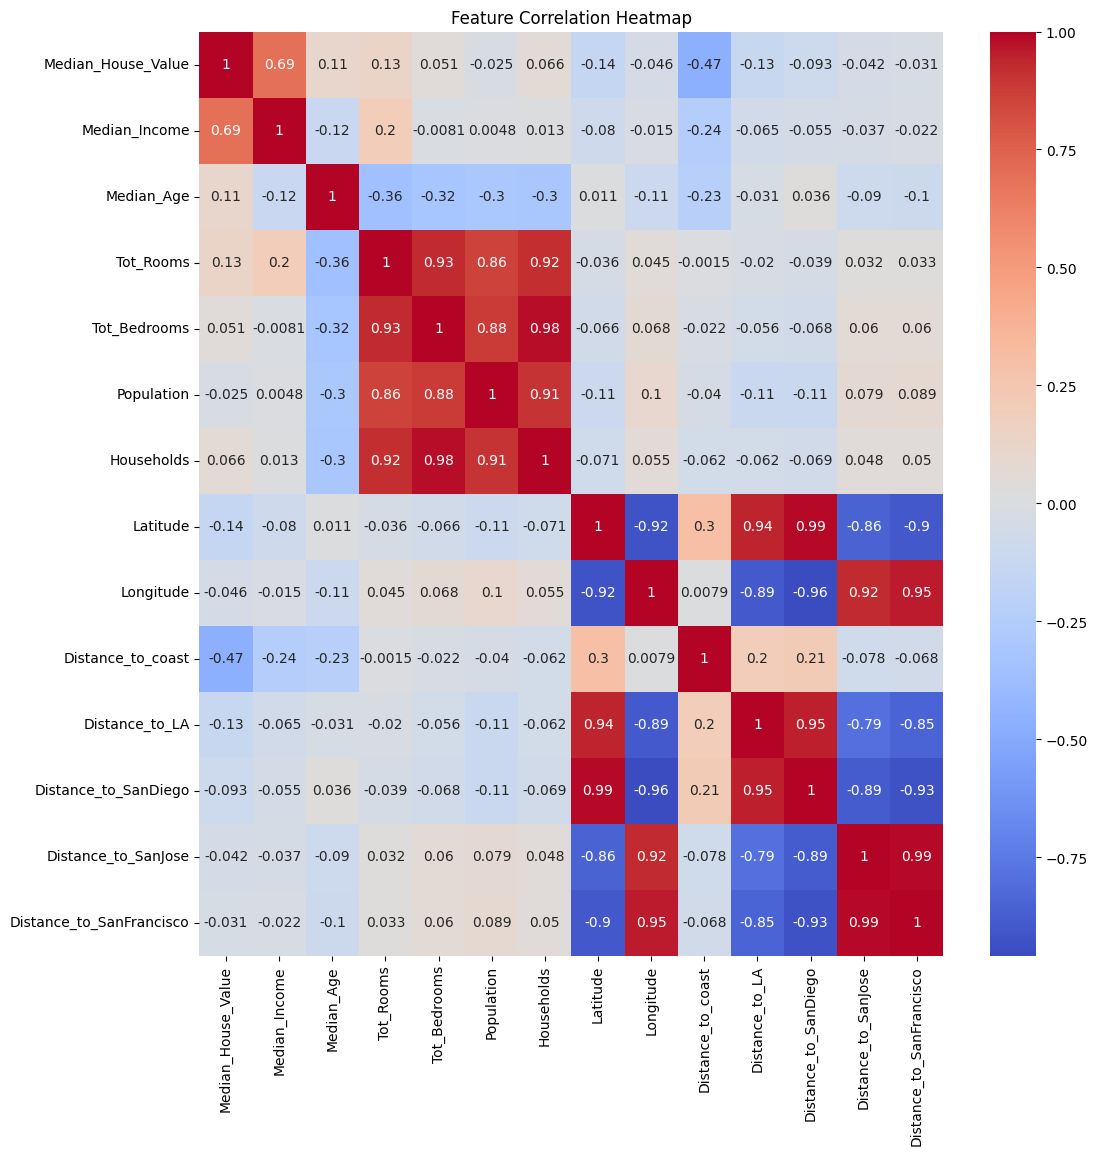

In [140]:
# 3. Visualizing the correlation between features
plt.figure(figsize=(12, 12))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")  # Correlation heatmap
plt.title("Feature Correlation Heatmap")
plt.show()

In [141]:
# 4. Feature Engineering - Adding new features
X = data.drop(columns=["Median_House_Value"])
y = data["Median_House_Value"]

# Creating new features that capture relationships between variables
X['rooms_per_household'] = X['Tot_Rooms'] / X['Households']
X['bedrooms_per_room'] = X['Tot_Bedrooms'] / X['Tot_Rooms']
X['population_per_household'] = X['Population'] / X['Households']

# 5. Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [142]:
# 6. Initialize the XGBoost model
model = XGBRegressor(n_estimators=5000, learning_rate=0.1, random_state=42, n_jobs=10, early_stopping_rounds=1000)

# Fit the model with early stopping on the test set
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=1000,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=10, num_parallel_tree=None, ...)

In [143]:
# 7. Make predictions on the test set
y_pred = model.predict(X_test)

# 8. Calculate and print the Mean Absolute Percentage Error (MAPE), and Mean Absolute Error (MAE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.4f} ({mape*100:.2f}%)")

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.4f}")

MAPE: 0.1539 (15.39%)
MAE: 27390.6811


<Figure size 1000x800 with 0 Axes>

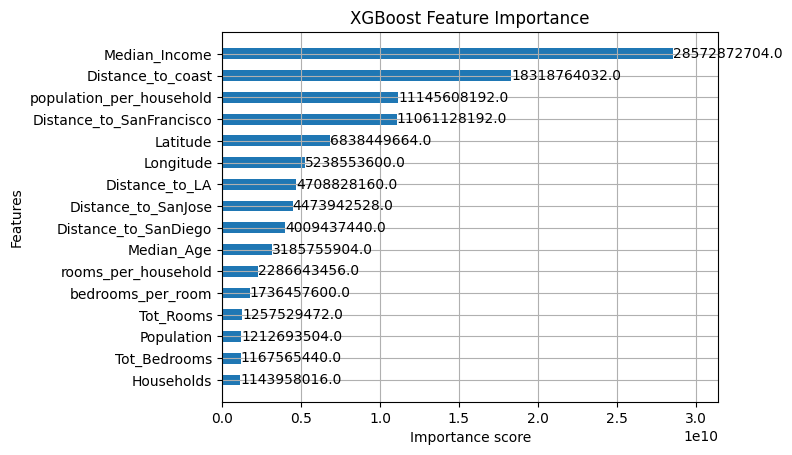

In [144]:
# 9. Visualizing Feature Importance
plt.figure(figsize=(10, 8))
plot_importance(model, importance_type='gain', height=0.5)  # Plotting feature importance
plt.title("XGBoost Feature Importance")
plt.show()

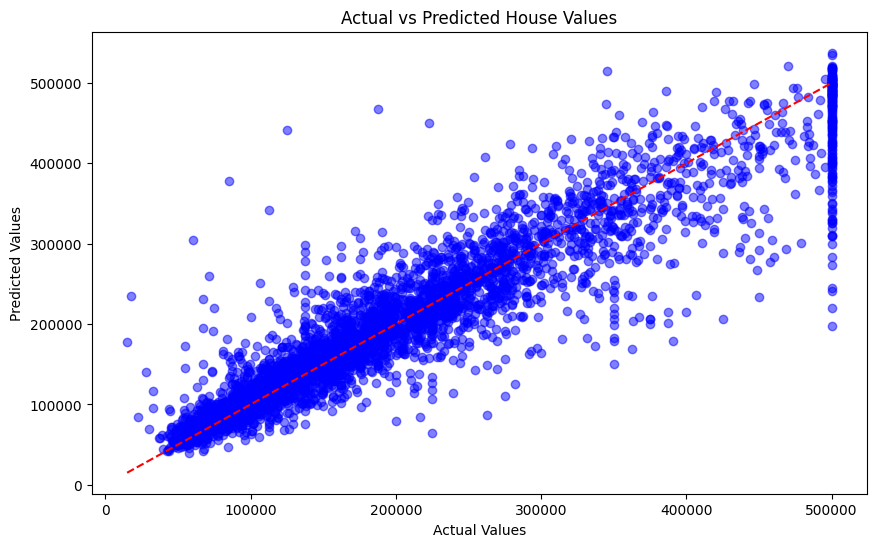

In [145]:
# 10. Visualizing the prediction vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)  # Scatter plot of true vs predicted values
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # Line for perfect predictions
plt.title("Actual vs Predicted House Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()